# <center>Online News Popularity Shares Prediction Model

## Introduction:

With the sharp rise in social networking and the use of personal electronic devices in recent years, the sharing of online news has also risen greatly. Something important for authors and organizations to consider when writing online articles is what variables will play into the popularity of their pieces in order to maximize distribution and profit. For online media distribution, the number of “shares” that a piece receives can be an effective measure of its popularity. From a study conducted by Jamali and Nikzad (2011), articles with shorter titles were downloaded more than ones with longer titles. Additionally, as stated by The Washington Post (Dewey, 2016), the majority of the population will share links without even reading any of the content. These findings contribute to the concept that if the title of an article is brief and captivating, the reader will be more inclined to share it with others. Other possible factors to consider on the topic of article titles would be their subjectivity and polarity, which may also have an influence on how often they are shared.


Not only the title, but the metadata can play a significant role in the number of people sharing the article. Since metadata contains keywords linked to the content, the keywords associated with it should be appropriate so that the articles have an increased chance of showing up in the search results. Without the keywords in metadata, the article will not be accessible for many users and therefore have little to no shares. 

Digital media platforms largely responsible for publishing online news articles mostly have short visit durations; according to Simlarweb (2021), Mashable’s readers visit articles for only 34 seconds on average, implying that many people may share online articles after only reading the title and not the entire content.


These findings motivated us to ask: based on information available before reading an article, can we predict the number of shares? We propose that the following variables can predict article shares: the number of words in the title, the number of keywords in the metadata, and the absolute polarity of the article title.


The dataset we have chosen to work with is the Online News Popularity dataset from 2015. We will be using OnlineNewPoplarity.csv. This dataset contains 61 different attributes and outlines the genre of 39797 articles from Mashable. 


## Methods and Results:

This analysis makes use of the following R libraries which will be necessary to run the code: tidyverse, repr, tidymodels, GGally, and cowplot.


The data was provided in a .csv format, so it was possible to read it from the URL using read_csv.  The first step was to prepare and clean the data. First, human-unreadable variable names such as “n_tokens_title” were changed to names such as “title_length”. Then, useful predictors for the prediction were selected from the dataframe. The outcome variable was “shares”, and potential predictor variables were chosen as elements that would be available to the reader before they had read the article. These were:  “title_length”, “meta_tags”, “title_subjectivity”, “absolute_title_subjectivity”, “title_sentiment_polarity”, and “absolute_title_sentiment_polarity”.


In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)
library(cowplot)


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [2]:
data <- read_csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vSTyupJYW8-dOI7rTKOVE-bMT4M_8UnVnRLOJGavyVh33-4wHTkP4Q-uWX9mwMQul2kxMl8aJLR0FHB/pub?output=csv")
#loads data from the original source on the web 

Parsed with column specification:
cols(
  .default = col_double(),
  url = col_character()
)

See spec(...) for full column specifications.



In [3]:
named_data <- data %>%
    rename(
        absolute_title_subjectivity = abs_title_subjectivity,
        title_length = n_tokens_title,
        absolute_title_sentiment_polarity = abs_title_sentiment_polarity,
        meta_tags = num_keywords
    )

#wrangles and cleans the data from it's original (downloaded) format to the format necessary for the planned analysis

In [4]:
tidy_data <- named_data %>%
    select(title_length, meta_tags, title_subjectivity,absolute_title_subjectivity,title_sentiment_polarity,absolute_title_sentiment_polarity, shares)
#wrangles and cleans the data from it's original (downloaded) format to the format necessary for the planned analysis

After a 75% train/test split, data visualizations were prepared using the training data to assess the value of the planned predictor variables. The variables were assessed using ggpairs() (Figure 1). After viewing the interactions with shares, only title_length, meta_tags, and absolute_title_sentiment_polarity were selected. The title_length and meta_tags variables showed the strongest correlations to shares of any of the factors. Both of these correlations were positive - as one variable increased so did the other. The title_length variable had a more complex relationship to shares, showing increased shares with moderate values (eg. 10 words) and decreased with higher or lower values. No other variable showed a clear visual relationship to shares. The next highest correlational values were title_subjectivity and absolute_title_subjectivity; these were excluded as they had significant correlations to absolute_title_sentiment_polarity (0.713 and -0.395, respectively) and each other (-0.483). None of the selected variables showed any meaningful relationship to each other either visually or in correlation.


In [5]:
set.seed(1234)
publishing_split <- initial_split(tidy_data, prop = 0.75, strata = shares)
publishing_train <- training(publishing_split)
publishing_test <- testing(publishing_split)

print("Table 1: Training Data Head")
table_1 <- head(publishing_train)
table_1

[1] "Table 1: Training Data Head"


title_length,meta_tags,title_subjectivity,absolute_title_subjectivity,title_sentiment_polarity,absolute_title_sentiment_polarity,shares
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
12,5,0.5000000,0.0000000,-0.1875000,0.1875000,593
9,4,0.0000000,0.5000000,0.0000000,0.0000000,711
9,7,0.0000000,0.5000000,0.0000000,0.0000000,1200
10,9,0.6428571,0.1428571,0.2142857,0.2142857,855
12,9,1.0000000,0.5000000,0.5000000,0.5000000,891
11,7,0.1250000,0.3750000,0.0000000,0.0000000,3600


_This table displays the chosen predictors used to predict the number of shares. We chose these variables based on the their interaction with the number of shares._

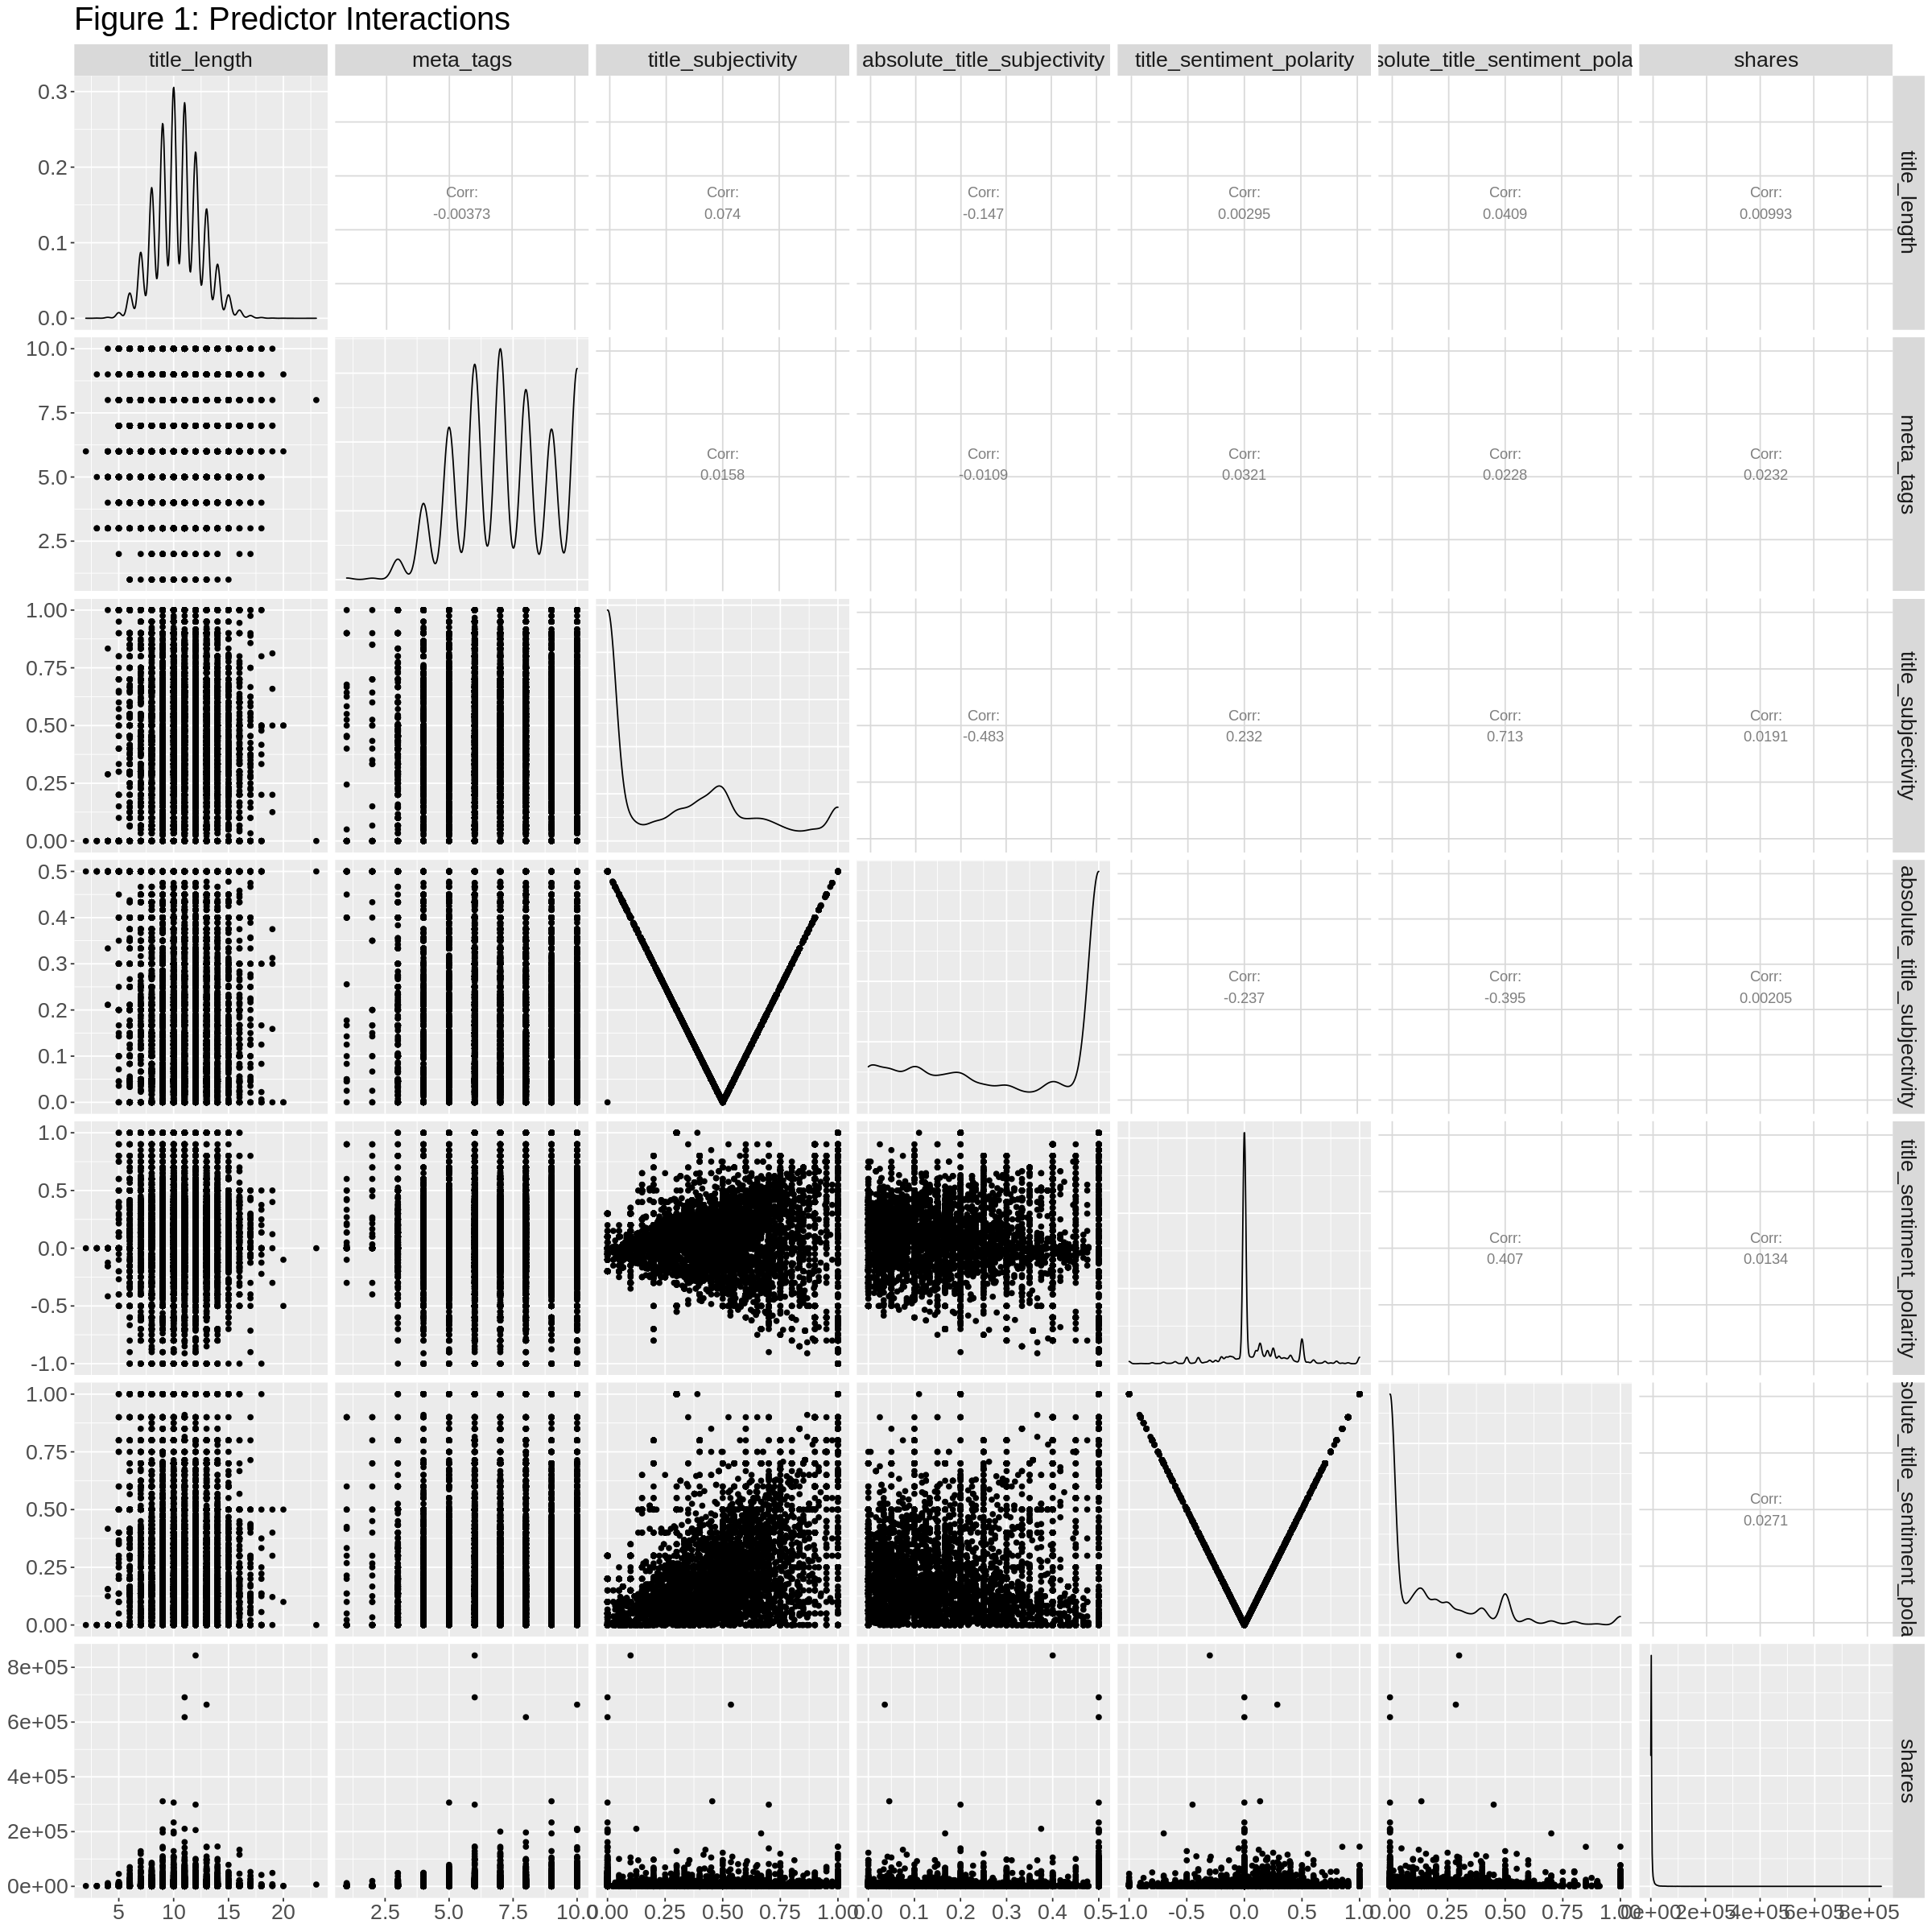

In [6]:
options(repr.plot.width = 20, repr.plot.height = 20)

fig_1 <- publishing_train %>%
    ggpairs() + 
    ggtitle("Figure 1: Predictor Interactions")+
    theme(text = element_text(size = 20))

fig_1

#performs a summary of the data set that is relevant for exploratory data analysis related to the planned analysis 
#creates a visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis

_The visualization allows us to see the interaction and correlation with our proposed predictor, “number of shares”. From this visualization, we chose variables that will be utilized in our model._

In [7]:
share_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>% 
       set_engine("kknn") %>%
       set_mode("regression") 


share_recipe <- recipe(shares ~ title_length+absolute_title_sentiment_polarity+meta_tags, data = publishing_train) %>%
       step_scale(-shares) %>%
       step_center(-shares)

A K-nearest neighbours regression was selected as the predictive model, as the outcome was numerical and observed relationships were not all linear (ruling out linear regression).  The numerical predictors in the data were scaled in the recipe. This would prevent large-scaled variables from having a larger impact on the prediction. The cross-validation was set to have five folds and tune over k values of 25-400, stepping up by 25 each iteration.


In [8]:
shares_vfold <- vfold_cv(publishing_train, v = 5, strata = shares)

share_workflow <- workflow() %>%
       add_recipe(share_recipe) %>%
       add_model(share_spec)

gridvals <- tibble(neighbors = 25:500) %>%
    filter(neighbors %% 25 == 0 )

share_results <- share_workflow %>%
    tune_grid(resamples = shares_vfold, grid = gridvals) %>%
    collect_metrics()


#performs the data analysis

_This is the cross validation results. From our cross validation results, we will find the neighbours that provides us the smallest rmse value._

The k value yielding the minimum RMSPE value (k=475) was selected for the final model.

In [9]:
share_min <- share_results %>%
    filter(.metric == "rmse") %>%
    arrange(mean) %>% 
    slice(1)

print("Table 2: Best Predictive Model")
table_2 <- share_min
table_2

[1] "Table 2: Best Predictive Model"


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
475,rmse,standard,11115.62,5,1653.028,Model19


_This table displays the predicted neighbours that we should use in our model for the testing data set. 475 neighbours should be used based on our model._

After refitting the model to the training data, it was evaluated using the testing data. The final RMSPE value was 11738.82. This meant that any prediction made by the model was liable to have an error of approximately 11739 shares.

In [10]:
k_min <- share_min %>%
          pull(neighbors)

share_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) %>%
          set_engine("kknn") %>%
          set_mode("regression")

share_best_fit <- workflow() %>%
          add_recipe(share_recipe) %>%
          add_model(share_best_spec) %>%
          fit(data = publishing_train)

share_preds <- share_best_fit %>%
           predict(publishing_test) %>%
           bind_cols(publishing_test)

table_3 <- share_preds %>%
           metrics(truth = shares, estimate = .pred)
print("Table 3: Model Testing Metrics")
table_3

[1] "Table 3: Model Testing Metrics"


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,1.173882e+04
rsq,standard,4.980522e-04
mae,standard,3.252393e+03


_This table displays the results of the testing data set._

The standard deviation of the testing set was calculated at 11736.01 to act as a comparison to the model’s performance.

In [11]:
lm_rmspe <- table_3 %>%
          filter(.metric == "rmse") %>%
          select(.estimate) %>%
          pull()

std_dev <- pull(summarize(publishing_test, sd(shares)))
mean <- pull(summarize(publishing_test, mean(shares)))


print("Table 4: RMSPE and Standard Deviation")
table_4 <- tibble("Test RMSPE"=lm_rmspe,"Test Data Standard Deviation" = std_dev, "RMSPE:StdDev Proportion" =lm_rmspe/std_dev )
table_4

#creates a visualization of the analysis 

[1] "Table 4: RMSPE and Standard Deviation"


Test RMSPE,Test Data Standard Deviation,RMSPE:StdDev Proportion
<dbl>,<dbl>,<dbl>
11738.82,11736.01,1.00024


_This table compares the RMSPE to the standard deviation. This is significant because it shows that the ratio between the 2 are very close with RMSPE being a little bit higher than the test data standard deviation. This tells us our model has chances of prediction error but they are very small compared a model that guesses the average number of shares for every prediction._

A histogram was created to show the distribution of the number of articles by their number of shares. Vertical lines indicated where the mean of the shares were and where the RMSPE error could be expected to place any “average” prediction.


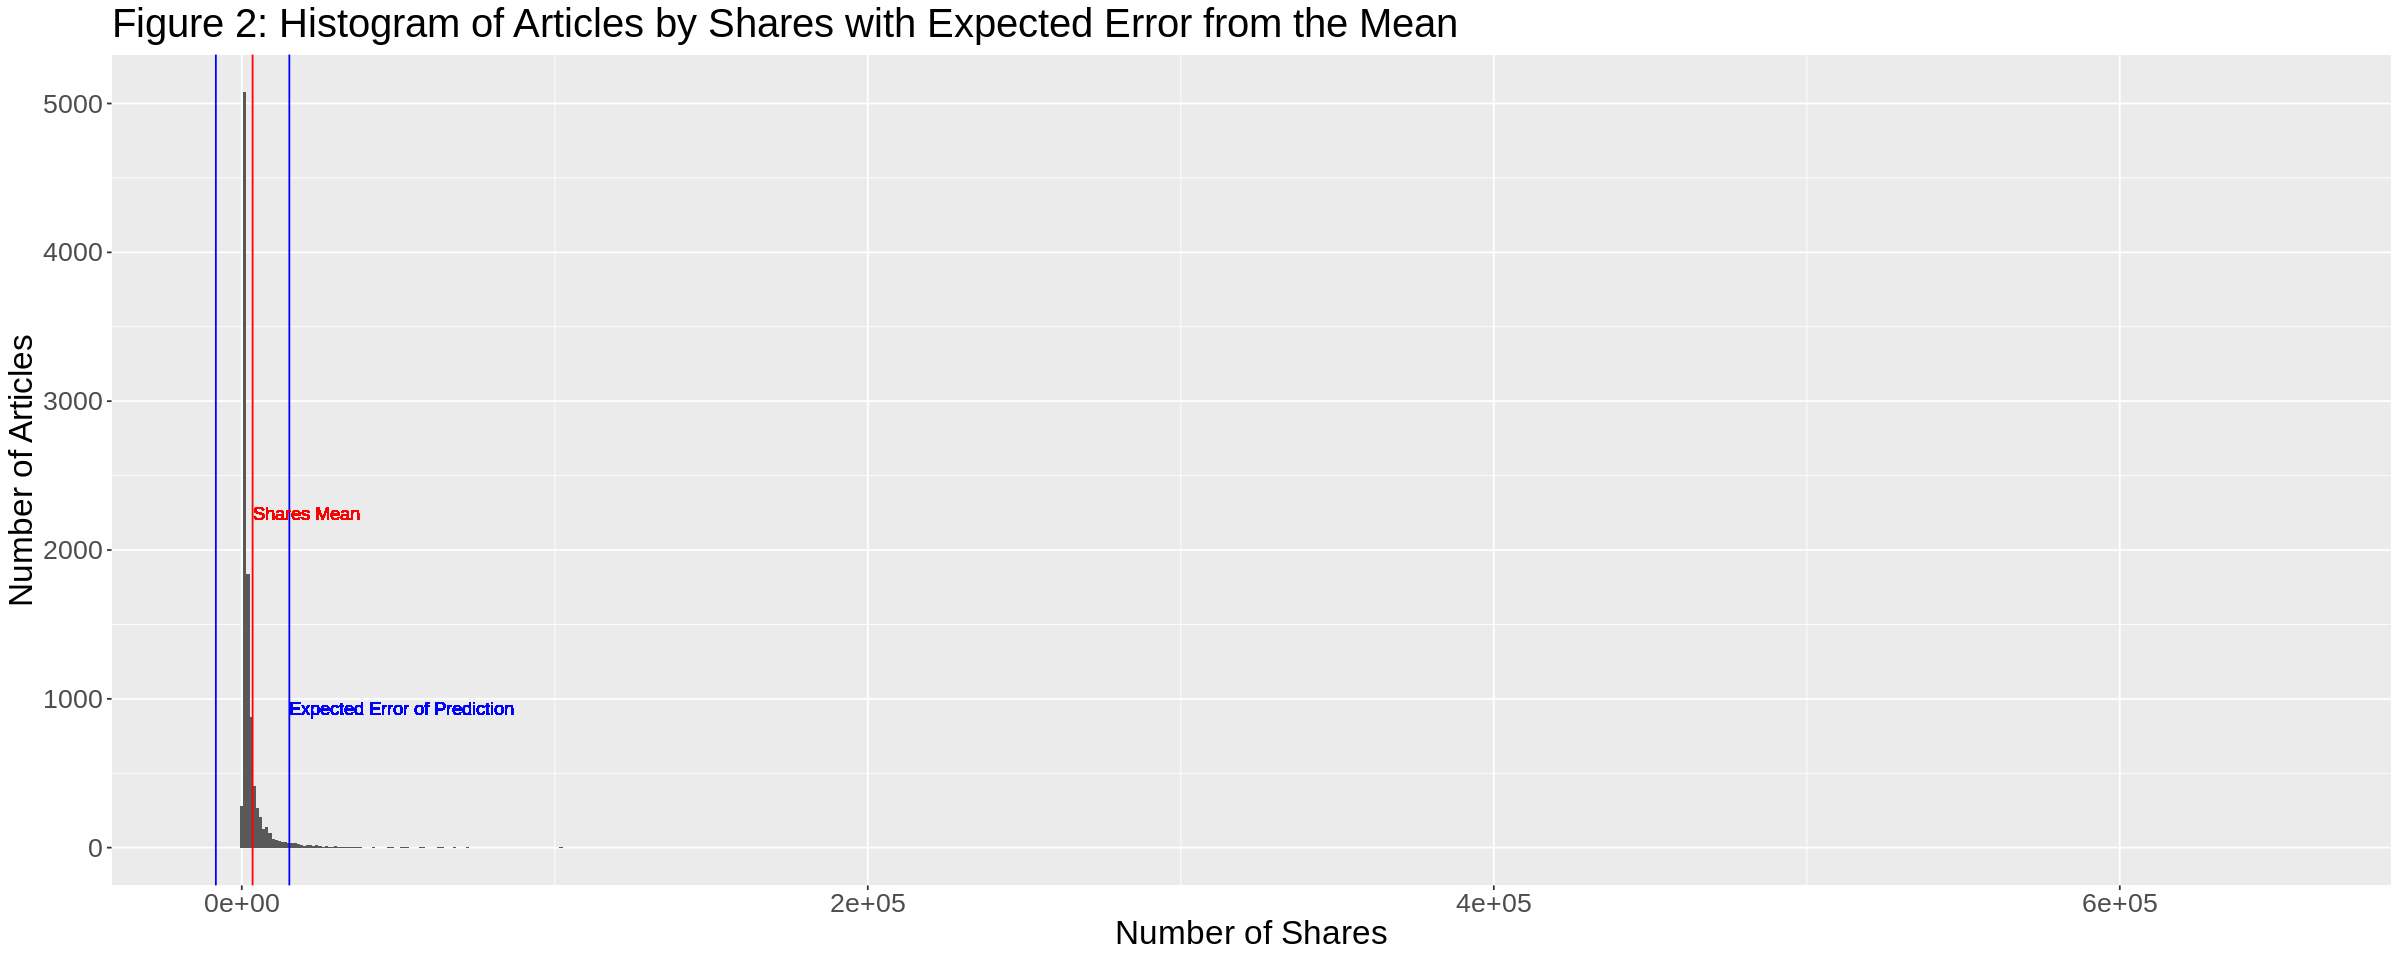

In [12]:
line.data <- data.frame(xintercept = c(mean+lm_rmspe, mean-lm_rmspe,mean ), Lines = c("Expected Prediction Error", "Expected Prediction Error", "Testing Data Mean"),
  color = c("blue", "blue", "red"), stringsAsFactors = FALSE)


options(repr.plot.width = 20, repr.plot.height = 8)

figure_2 <- ggplot(publishing_test, aes(x=shares)) +
    geom_histogram(binwidth=1000)+
    geom_vline(aes(xintercept=mean+lm_rmspe),color="blue")+
    geom_vline(aes(xintercept=mean-lm_rmspe),color="blue")+
    geom_vline(aes(xintercept=mean),color="red")+
    geom_text(aes(x=mean+lm_rmspe, label="Expected Error of Prediction", y=20), colour="blue", angle=0, vjust = -10, hjust = 0)+
    geom_text(aes(x=mean, label="Shares Mean", y=20), colour="red", angle=0, hjust = 0, vjust = -25)+
    labs(x="Number of Shares",y="Number of Articles", title="Figure 2: Histogram of Articles by Shares with Expected Error from the Mean")+
    theme(text = element_text(size = 20))

figure_2


_This figure demonstrates the distribution of articles by their total shares. The red line indicates the mean number of shares in the testing data, whereas the blue lines represent the error range we could expect using our model on an average article._

In [13]:
options(repr.plot.width = 8, repr.plot.height = 8)


title_length_plot <- ggplot(publishing_test, aes(x = title_length, y = shares)) +
  geom_point(alpha = 0.2) +
  labs(x="Length of the Article Title (Words)",y="Shares")+
  geom_line(data = share_preds, aes(x = title_length, y = .pred), color = "blue")+
  ggtitle("Figure 5: Shares by Title Length with Predictions")+
  theme(text = element_text(size = 20))

In [14]:
metadata_plot <- ggplot(publishing_test, aes(x = meta_tags, y = shares)) +
  geom_point(alpha = 0.2) +
  labs(x="Number of Keywords in Metadata (Words)",y="Shares")+
  geom_line(data = share_preds, aes(x = meta_tags, y = .pred), color = "blue")+
  ggtitle("Figure 6: Shares by Metadata Tags with Predictions")+
  theme(text = element_text(size = 20))

In [15]:
title_polarity_plot <- ggplot(publishing_test, aes(x = absolute_title_sentiment_polarity, y = shares)) +
  geom_point(alpha = 0.2) +
  labs(x="Absolute Title Polarity (Ratio)", y="Shares")+
  geom_line(data = share_preds, aes(x = absolute_title_sentiment_polarity, y = .pred), color = "blue")+
  ggtitle("Figure 7: Shares by Title Polarity with Predictions")+
  theme(text = element_text(size = 20))

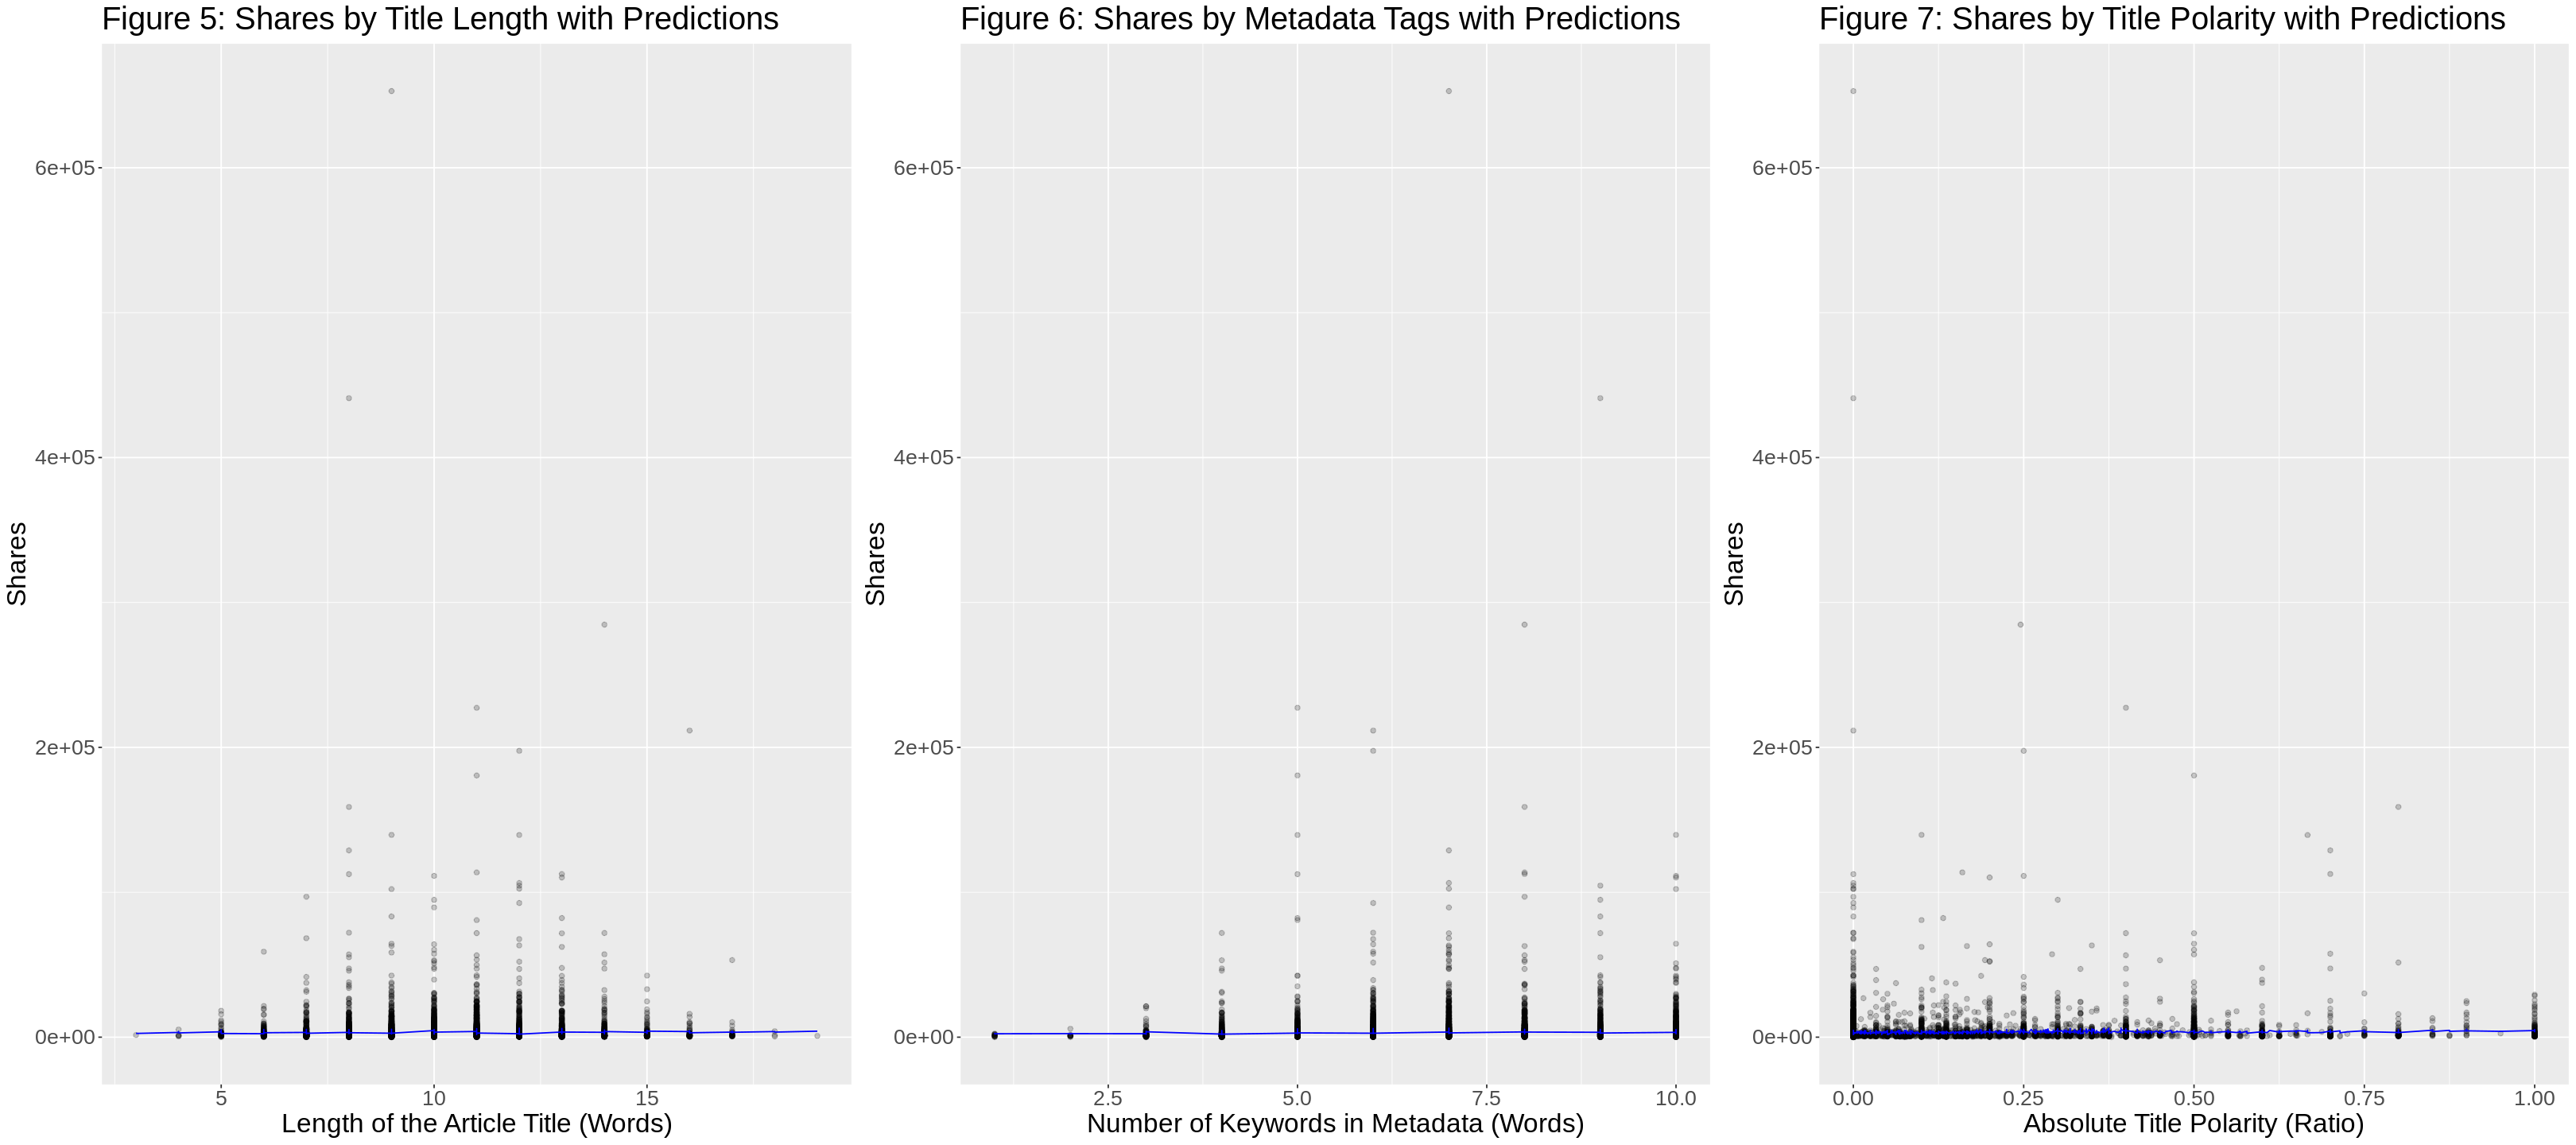

In [16]:
options(repr.plot.width = 27, repr.plot.height = 12)

figure_567 <- plot_grid(title_length_plot,
                   metadata_plot,
                   title_polarity_plot,
                   ncol = 3) +
            ggtitle("Shares by the Predictor Variables")
figure_567

_These figures display article shares as a function of the three predictor variables. The blue lines represent the predictions that would be made by the model._

In [17]:
explore_data <- tidy_data %>%
    mutate (Popular = shares > 1500) %>%
    select(-shares)

table_5 <- explore_data %>%
            group_by(Popular) %>%
            summarize(n=n()) %>%
            select(Popular, n)

print("Table 5: Distribution of Popular-Unpopular Split")
table_5

`summarise()` ungrouping output (override with `.groups` argument)



[1] "Table 5: Distribution of Popular-Unpopular Split"


Popular,n
<lgl>,<int>
FALSE,21405
TRUE,18239


Following the performance of the model, more thorough analysis of all possible predictor variables was conducted on the full dataset, excluding only “url” and “timedelta” which were classified as non-predictive by the dataset source. The data were roughly split into high and low share-value sets (greater than or less than 1500 shares) and compared via histogram distribution over all title-based “predictive” variables. 


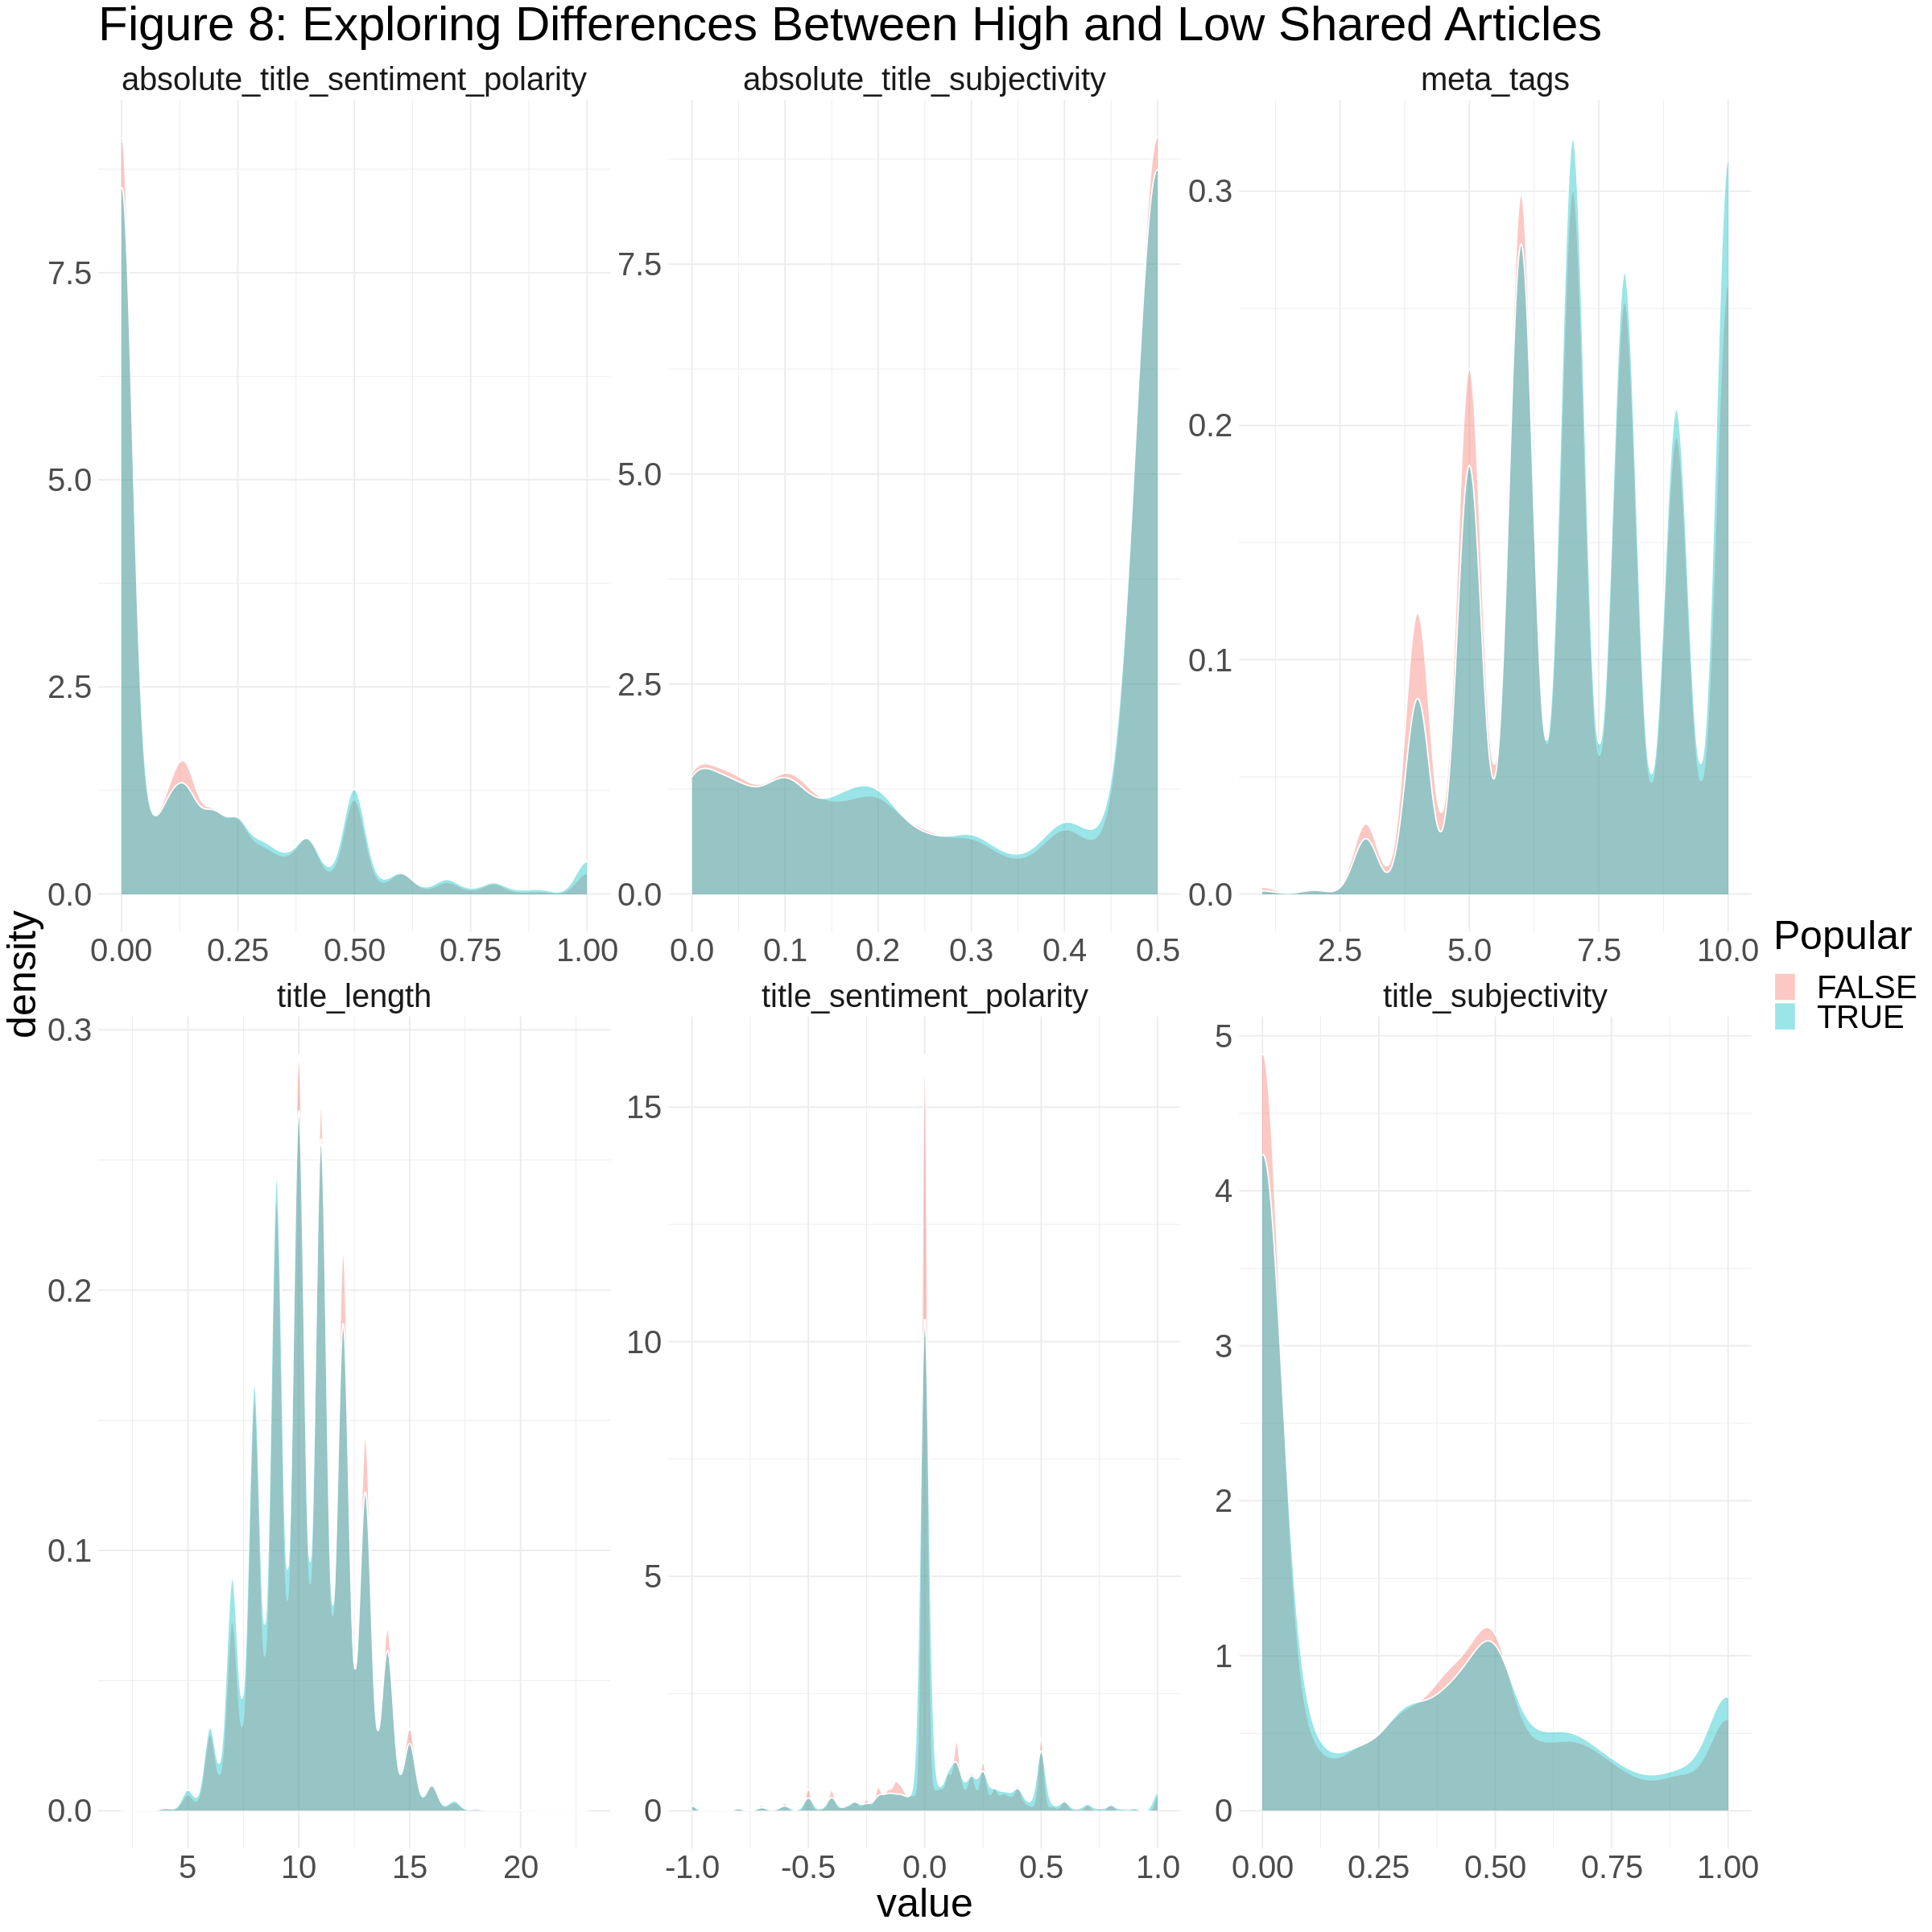

In [20]:
options(repr.plot.height = 20, repr.plot.width = 20)
figure_8 <- explore_data %>%
            pivot_longer(cols = -Popular, names_to = 'category', values_to = 'value')  %>% 
            ggplot(aes(value, fill = Popular)) +
                geom_density(alpha = 0.4, colour = 'white') +
                facet_wrap(~ category, scales = 'free') +
                theme_minimal() +
                theme(text = element_text(size = 30))+
                ggtitle("Figure 8: Exploring Differences Between High and Low Shared Articles")
figure_8

_This figure shows the distribution histograms of two groups of the dataset, high shares and low shares, compared across all of the possible title-related predictor variables._

## Discussion:

The final RMSPE value on the testing data was found to be slightly greater than the standard deviation of the testing data (Table 4). This roughly indicated that the model was slightly worse than a model which guesses the average number of shares for every prediction. However, the difference was small enough to be effectively negligible. Figure 2 demonstrates the inefficacy of the model, as nearly all articles fall within the margin of error.



Overall, the model indicated that the chosen predictors, which did interact with the number of shares, did not effectively predict the number of shares that an article would accrue. Figures 5, 6, and 7 show that the predictor lines pass through the areas of maximum point density, but are still prone to error due to the large vertical spread of data points. Ultimately, none of these variables had a strong enough connection to the outcome.

The exploratory post-model analysis yielded clear results (Figure 8). As can be seen by the near complete overlap of the blue (high-shares) and pink (low-shares) distributions, there is no effective difference in the values for these predictors between high and low shared articles. This indicates that there is no title-based predictor that will function adequately on its own to predict article shares.


In general, the results were not what we expected to find. From our preliminary data analysis, the number of keywords in the metadata had a weak positive correlation with respect to the number of shares. We were hoping to create a model to predict that as the number of keywords in the metadata increased, so does the number of shares for the specific article. In addition, we were also hoping that our model would provide an RMSPE value that is greater than the standard deviation of the testing data. However, it appears that our chosen predictors did not have an impactful interaction with “shares'' based on our results. Thus, concluding that there will be no predictors that will be impactful in our predicatory model. When we investigated the chosen predictors, there were significant interactions with “shares” which prompted us to believe that our model would predict slightly better than a model that predicted the average number of shares for every prediction. This meant that the model was somewhat more precise than the one that predicted the average amount of shares for each prediction. However, this was not the results illustrated. In the end, the differences in the RMSPE value is small enough so that it can be negligible. To conclude, although our model was not the best at predicting the number of shares based on the number of words in the title, the number of keywords in metadata, and the absolute polarity of the article title, the root mean square prediction error was negligible. The results were not what we were expecting but since the differences in the RMSPE are small enough to be negligible, our model would be considered valid to a certain extent. 


As the length and content of the title and the keywords of metadata do not significantly increase the number of shares, the author should not solely rely on the title and metadata to predict the popularity of their article. However, the title and metadata could still play a role in the article’s popularity, so they should not be neglected. Because significant portion of Mashable’s readers are active users of social media apps like Reddit and Facebook (SimilarWeb, 2021) , which are widely used for sharing external sources, having an intriguing title and suitable keywords for metadata that effectively support the article’s topic can attract more people to share it online. Although these two factors are not perfect predictors, if a title is too long or does not have enough subjectivity or polarity, or if metadata contains no appropriate keywords, the article will very likely not become popular. Simply, as a final step before officially publishing their news articles, it is recommended that authors ensure the title is concise and metadata is appropriately labelled.


From our predictive model analysis on the impact of variables in article titles in determining article popularity, future research areas and questions can be unveiled. For example, conducting future modelling analyses on the topics of how style of writing, the difficulty of language, originality of topic, or other related areas, may lead to more findings of how to increase the popularity of online articles. Some specific questions that would benefit from future analyses could be: how can authors increase the likelihood that readers will read their article in full?  Is the success of shorter news article titles also mirrored for title length in online news videos? Do the successful keywords included in metadata follow any temporal trends, such as the four seasons? Can the use of images or graphics be equally impactful into the variability of an article’s popularity as its title length? Investigating and answering these questions will provide further knowledge to help authors of articles increase the popularity of their work. 

## References:

Dewey, C. (2019, April 28). 6 in 10 of you will share this link without reading it, a new, depressing study says. The Washington Post. https://www.washingtonpost.com/news/the-intersect/wp/2016/06/16/six-in-10-of-you-will-share-this-link-without-reading-it-according-to-a-new-and-depressing-study/.


Fernandes, K., Vinagre, P., Cortez , P., & Sernadela, P. (2015, January 8). Online News Popularity Data Set. UCI machine Learning Repository: Online News popularity data set. https://archive.ics.uci.edu/ml/datasets/Online+News+Popularity

Jamali, H.R., & Nikzad M. (2011, May 19). Article title type and its relation with the number of downloads and citations.    AKJournals.https://akjournals.com/view/journals/11192/88/2/article-p653.xml 


Mashable.com traffic Ranking & marketing analytics. Similarweb. (2021, July). https://www.similarweb.com/website/mashable.com/. 
